In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
physical_devices = tf.test.gpu_device_name()
print(physical_devices)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import datasets

import numpy as np

/device:GPU:0


c:\Users\Tim\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ds_preprocess_image(entity):
    img = entity["image"]
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    entity["image"] = resize
    return entity

In [3]:
def preprocess_image(img):
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    return np.array(resize)

In [4]:
preprocess = False
if preprocess:

    # load image data

    ds = datasets.load_from_disk("../../data/diffusion_and_real/")

    train_images = np.array([preprocess_image(image) for image in ds["train"]["image"]])
    train_labels = np.array(ds["train"]["label"])

    vali_images = np.array([preprocess_image(image) for image in ds["vali"]["image"]])
    vali_labels = np.array(ds["vali"]["label"])

    test_images = np.array([preprocess_image(image) for image in ds["test"]["image"]])
    test_labels = np.array(ds["test"]["label"])

    ds_map = ds.map(ds_preprocess_image)

    ds_tf = ds_map.with_format("tf")

    ds_tf.save_to_disk("ds-tf")
else:
    ds_tf = datasets.load_from_disk("ds-tf-224")

In [5]:
ds_tf_train = ds_tf["train"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_vali = ds_tf["vali"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_test = ds_tf["test"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

c:\Users\Tim\miniconda3\lib\site-packages\datasets\arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [6]:
ds_tf_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(8, (5, 5), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(8, (7, 7), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(15)) #removed for now to keep the network simple and fast 
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 123210)            0         
                                                                 
 dense (Dense)               (None, 15)                1848165   
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,848,461
Trainable params: 1,848,461
Non-trainable params: 0
______________________________________________

In [8]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 224, 224, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
conv2d (None, 224, 224, 3) float32
max_pooling2d (None, 222, 222, 10) float32
flatten (None, 111, 111, 10) float32
dense (None, 123210) float32
dense_1 (None, 15) float32


[None, None, None, None, None]

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # dear god let this be the right loss function from_logits=False BinaryCrossentropy
              metrics=['accuracy'])

history = model.fit(ds_tf_train, epochs=7, batch_size = 32, max_queue_size=1, shuffle=True,
                    validation_data=ds_tf_vali
                    )

Epoch 1/7


6000/6000 [==============================] - 70s 11ms/step - loss: 11.6513 - accuracy: 0.5689 - val_loss: 0.7079 - val_accuracy: 0.5950
Epoch 2/7
6000/6000 [==============================] - 49s 8ms/step - loss: 0.6450 - accuracy: 0.6168 - val_loss: 0.7227 - val_accuracy: 0.5610
Epoch 3/7
6000/6000 [==============================] - 49s 8ms/step - loss: 0.6231 - accuracy: 0.6482 - val_loss: 0.7729 - val_accuracy: 0.6270
Epoch 4/7
6000/6000 [==============================] - 48s 8ms/step - loss: 0.5406 - accuracy: 0.6919 - val_loss: 0.7820 - val_accuracy: 0.6200
Epoch 5/7
6000/6000 [==============================] - 77s 13ms/step - loss: 0.4786 - accuracy: 0.7323 - val_loss: 0.8374 - val_accuracy: 0.6210
Epoch 6/7
6000/6000 [==============================] - 49s 8ms/step - loss: 0.4195 - accuracy: 0.7691 - val_loss: 1.0267 - val_accuracy: 0.6230
Epoch 7/7
6000/6000 [==============================] - 48s 8ms/step - loss: 0.4017 - accuracy: 0.7873 - val_loss: 0.9690 - val_accuracy: 0.6190

In [10]:
model.save("CNN-exp")

INFO:tensorflow:Assets written to: CNN-exp\assets


INFO:tensorflow:Assets written to: CNN-exp\assets


334/334 - 3s - loss: 1.0519 - accuracy: 0.6090 - 3s/epoch - 10ms/step


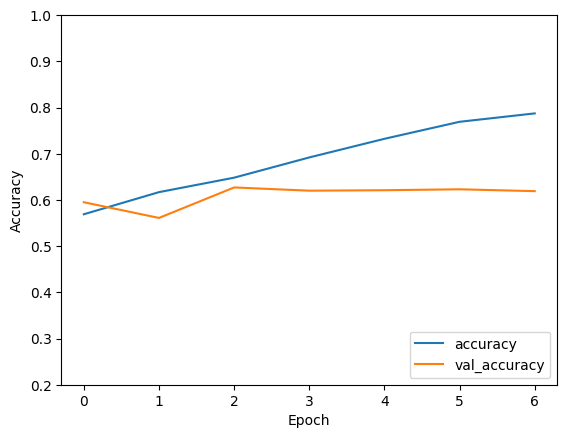

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_tf_test, verbose=2)


In [12]:
print(test_acc)


0.609000027179718


In [13]:
true_label = ds_tf["test"]["label"]

In [14]:
# eval test set
from tqdm import tqdm
# confusion matrix
predictions = []
res = model.predict(ds_tf_test, batch_size=10)
predictions = [1 if pred > 0.5 else 0 for pred in res]

334/334 [==============================] - 3s 7ms/step


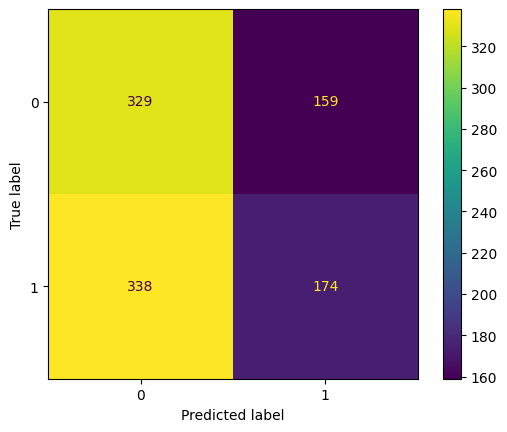

{'0': {'precision': 0.49325337331334335,
  'recall': 0.6741803278688525,
  'f1-score': 0.5696969696969697,
  'support': 488.0},
 '1': {'precision': 0.5225225225225225,
  'recall': 0.33984375,
  'f1-score': 0.41183431952662725,
  'support': 512.0},
 'accuracy': 0.503,
 'macro avg': {'precision': 0.5078879479179329,
  'recall': 0.5070120389344263,
  'f1-score': 0.4907656446117985,
  'support': 1000.0},
 'weighted avg': {'precision': 0.5082391777084431,
  'recall': 0.503,
  'f1-score': 0.48887129280975433,
  'support': 1000.0}}

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


cm = confusion_matrix(true_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
classification_report(true_label, predictions, output_dict=True)


In [16]:
ds_tf_vali

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
model.evaluate(ds_tf_vali, verbose=2)

334/334 - 3s - loss: 0.9690 - accuracy: 0.6190 - 3s/epoch - 8ms/step


[0.9690219163894653, 0.6190000176429749]

In [18]:
res = model.predict(ds_tf_vali)

334/334 [==============================] - 3s 8ms/step


In [19]:
res

array([[3.20242018e-01],
       [4.66768682e-01],
       [5.28824031e-01],
       [6.86136067e-01],
       [4.66768682e-01],
       [9.63839352e-01],
       [6.51845336e-01],
       [1.97217152e-01],
       [4.66768682e-01],
       [4.66768682e-01],
       [6.29967988e-01],
       [4.67240158e-03],
       [9.94485438e-01],
       [4.66768682e-01],
       [1.00000000e+00],
       [2.65722871e-01],
       [1.48075268e-01],
       [7.52603829e-01],
       [3.12393993e-01],
       [2.31556848e-01],
       [9.99999881e-01],
       [1.09725086e-07],
       [1.00000000e+00],
       [7.02879190e-01],
       [9.99389887e-01],
       [1.12625314e-02],
       [4.49936152e-01],
       [9.94825780e-01],
       [4.66768682e-01],
       [4.88572836e-01],
       [8.69423091e-01],
       [9.67988670e-01],
       [1.00000000e+00],
       [4.66768682e-01],
       [1.68210253e-01],
       [7.11814702e-01],
       [4.66768682e-01],
       [4.12806600e-01],
       [2.93156773e-01],
       [4.66768682e-01],


In [20]:
res_2 = model.predict(ds_tf["test"]["image"])
res_2

32/32 [==============================] - 0s 7ms/step


array([[4.66768682e-01],
       [4.66768682e-01],
       [3.77014399e-01],
       [2.81945854e-01],
       [6.37236953e-01],
       [4.66768682e-01],
       [7.96804726e-01],
       [1.55512139e-03],
       [4.66768682e-01],
       [4.66768682e-01],
       [9.48101640e-01],
       [4.66768682e-01],
       [4.66768682e-01],
       [2.02230076e-04],
       [4.66768682e-01],
       [2.75303260e-04],
       [1.00000000e+00],
       [6.04479432e-01],
       [9.99997735e-01],
       [6.45948291e-01],
       [5.39787710e-01],
       [4.53899235e-01],
       [2.18808129e-02],
       [9.91158903e-01],
       [4.66768682e-01],
       [4.66768682e-01],
       [9.28755999e-01],
       [2.37557381e-01],
       [4.54328358e-01],
       [4.05633897e-01],
       [4.74297613e-01],
       [6.24457896e-01],
       [4.66768682e-01],
       [5.13723731e-01],
       [7.44530618e-01],
       [4.66768682e-01],
       [4.66768682e-01],
       [1.00000000e+00],
       [6.90784633e-01],
       [6.48983717e-01],
